In [1]:
import numpy as np
import matplotlib.pylab as plt
import warnings; warnings.filterwarnings('ignore')
from scipy.stats import norm, laplace, uniform

# Introduction to Bayesian Modeling (Part 2a)

## MCMC: Sampling from the posterior distribution

In this part of our course, we will slightly immerse into the theory of sampling from the posterior distribution. This will elucidate some details, e.g., why multiple chains may help, or how to deal with improperly set prior distributions.

Important: *stan* uses Hamiltonian Monte Carlo (HMC) sampler, which is a bit more complicated than the Metropolis sampler described below. However, the main (sampling) principles are common.

### Markov chain

The [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) $\{X_t\}$ is a sequence of *correlated* random variables $X_1, X_2,\ldots,X_t$ such that each $X_{t}$ depends only on $X_{t-1}$. The transition probability describes the Markov kernel

$$
X_{t+1}|X_{t}, X_{t-1},\ldots,X_{0} \sim K(X_{t}, X_{t+1}).
$$

The Markov kernel $K(X_t, X_{t+1})$ is usually represented by a probability density function $q(x_{t+1}|x_t)$.

[Markov chain in a glass with two different kernels :D](https://www.youtube.com/watch?v=VDOWS_JBCfw)

> **Example**
>
> Assume the Gaussian [random walk ](https://en.wikipedia.org/wiki/Random_walk)
>
>$$X_{t+1} = X_t + \varepsilon_t, \qquad \varepsilon_t\sim\mathcal{N}(0, 1).$$
>
> Then 
>
> $$K(X_t, X_{t+1}) \equiv \mathcal{N}(X_t, 1).$$
>
> *The following code generates two random walks:*

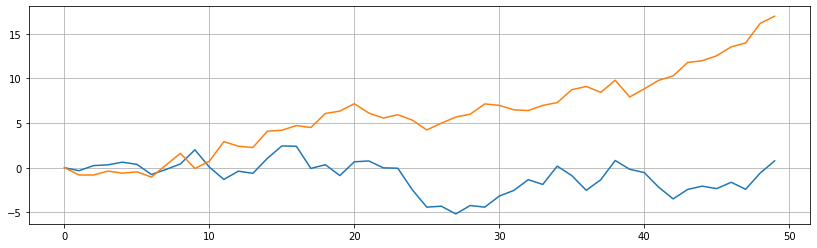

In [14]:
ndat = 50
x = np.zeros(ndat)
X = np.zeros(ndat)
for t in range(ndat-1):
    x[t+1] = x[t] + norm.rvs(loc=0, scale=1)
    X[t+1] = norm.rvs(loc=X[t], scale=1)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.plot(X)
plt.show()

An important property of (some) Markov chains is the existence of the limiting or [stationary distribution](https://en.wikipedia.org/wiki/Markov_chain#Stationary_distribution). Shortly, after reaching this distribution, say $f$, then for every $X_t \sim f$ the next $X_{t+1}\sim f$ too. That is, the chain follows the stationary distribution forever.

The idea of MCMC is to construct a chain whose stationary distribution is our distribution of interest, i.e., the posterior one. The chain then produces samples from this distribution, which allows us to estimate the shape of the true posterior from the samples histogram, the mean from the sample mean etc.

## Markov chain Monte Carlo (MCMC)

The main idea of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is as follows:
1. There is a target distribution with a density $f$, that is to be approximated by samples.
2. We construct a Markov kernel $K(X_t, X_{t+1})$ whose stationary distribution is that $f$.
3. We simulate a Markov chain $\{X_t\}$.

As the Markov kernel we usually use some "nice" probability density $q(y|x)$ that is easy to sample from. Surprisingly, there are not many requirements for it, as we will see shortly.

### Metropolis algorithm

The Metropolis algorithm is the most basic MCMC algorithm. It exploits symmetric proposal distributions (e.g., the normal distribution).

> **Algorithm for generating samples from the target density $f$**
>
> Initialisation: Select a suitable initial point $x_0$ and a proposal density $q(y|x)$.
>
> For $t=1,2,\ldots$:
>
> 1. Generate $x'$ from the proposal, $q(x'|x_t)$.
> 2. Calculate the acceptance probability (i.e., the transition from $x' \leftarrow x_t$):
>
>$$
\alpha = \min \left(1, \frac{f(x')}{f(x_t)} \right).
$$
>
> 3. Generate $u\sim\mathcal{U}(0,1)$.
> 4. If $u \leq \alpha$, accept the new sample: $x_{t+1} = x'$. Otherwise copy $x_{t+1}=x_t$.

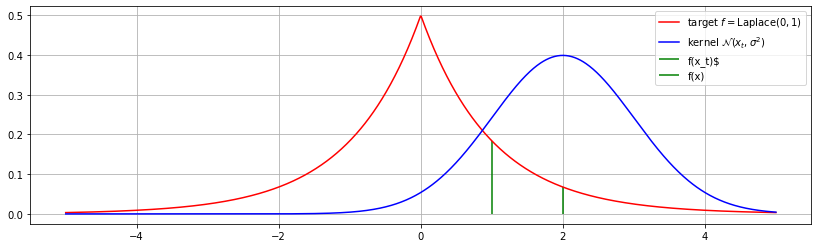

In [14]:
xt = 2
xnew = 1
proposal_scale = 1

xticks = np.linspace(-5, 5, 1000)
plt.figure(figsize=(14,4))
plt.plot(xticks, laplace.pdf(xticks), 'r', label=r"target $f = \mathrm{Laplace}(0, 1)$")
plt.plot(xticks, norm.pdf(xticks, loc=xt, scale=proposal_scale), 'b', label=r"kernel $\mathcal{N}(x_t, \sigma^2)$")
plt.vlines(xt, ymin=0, ymax=laplace.pdf(xt), color='green', label=r'f(x_t)$')
plt.vlines(xnew, ymin=0, ymax=laplace.pdf(xnew), color='green', label=r'f(x)')
plt.legend()
plt.show()

#### Example

Let's try to generate samples from the target - the [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution):
- target $f$ - Laplace distribution 
- proposal $q$ - normal distribution $\mathcal{N}(x_{t}, \sigma^2)$

Try to experiment with the proposal scale $\sigma$ (`proposal_scale`), the initial point $x_0$, and the number of samples `nsamples`.

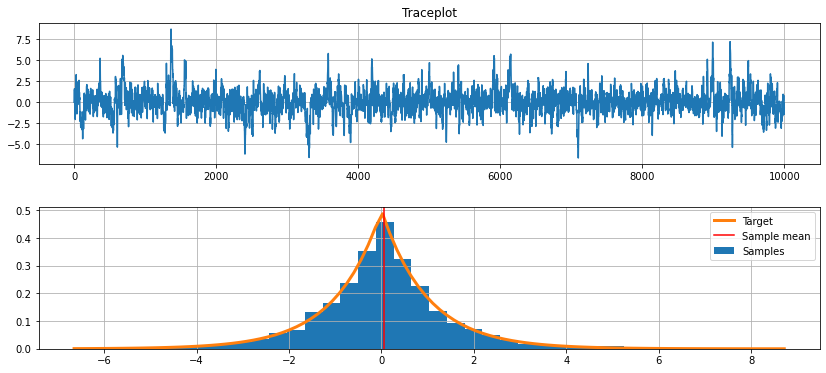

In [30]:
target = laplace()
proposal = norm
proposal_scale = 1

nsamples = 10000
x = np.zeros(nsamples)
x[0] = 0

for t in range(nsamples-1):
    x_candidate = proposal.rvs(loc=x[t], scale=proposal_scale)
    fraction = target.pdf(x_candidate)
    fraction /= target.pdf(x[t])
    alpha = np.min([1, fraction])
    u = uniform.rvs()
    if u <= alpha:
        x[t+1] = x_candidate
    else:
        x[t+1] = x[t]
        
plt.figure(1, figsize=(14,6))
plt.subplot(211)
plt.plot(x)
plt.title("Traceplot")
plt.subplot(212)
plt.hist(x, bins=40, density=True, label='Samples')
plt.plot(np.linspace(x.min(), x.max(),100), target.pdf(np.linspace(x.min(),x.max(),100)), lw=3, label='Target')
plt.axvline(x.mean(), color='red', label='Sample mean')
plt.legend()

### Issue 1: Autocorrelation (solution: thinning)

You're probably familiar with the acronym iid - *independent and identically distributed*. This is an important concept in probability and statistics. The problem with MCMC is that the kernel yields mutually dependent variables. That is, there is a strong *autocorrelation*:

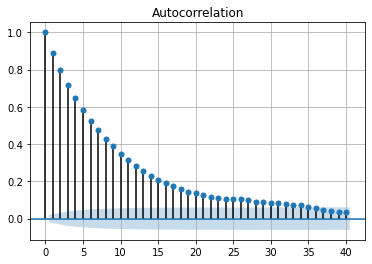

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x)
plt.show()

In order to somewhat suppress this autocorrelation, we usually employ **thinning**: we save only every $n$th sample:

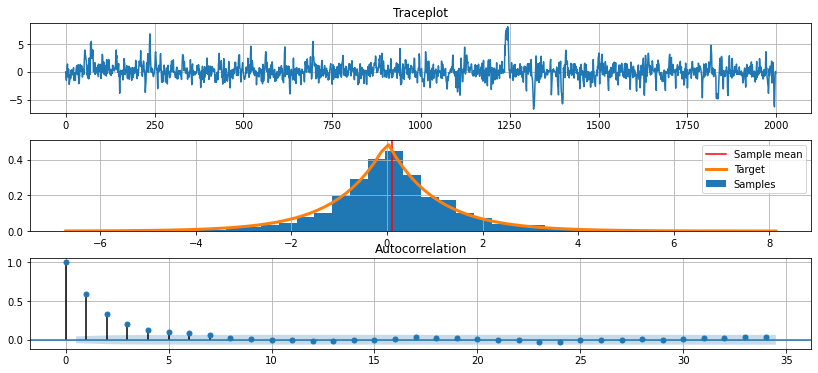

In [26]:
thinning = 5
x_thinned = x[::thinning]
plt.figure(1, figsize=(14,6))
plt.subplot(311)
plt.plot(x_thinned)
plt.title("Traceplot")
plt.subplot(312)
plt.hist(x_thinned, bins=40, density=True, label='Samples')
plt.axvline(x_thinned.mean(), color='red', label='Sample mean')
plt.plot(np.linspace(x_thinned.min(), x_thinned.max(),100), 
         target.pdf(np.linspace(x_thinned.min(),x_thinned.max(),100)),
         lw=3, label='Target')
plt.legend()
ax = plt.subplot(313)
plot_acf(x_thinned, ax=ax);
plt.show()

Of course, this comes at the cost of simulation overhead.

### Issue 2: Width of the Markov kernel

There is a strong trade off between:
- increasing the acceptance - this ensures a narow kernel, as the transition probability will be generally high, and
- increasing the exploration ability - this ensures a wide kernel, but the transition probabilities will be often low.

The optimality of our choice can be assessed from the trace plot. For example, let us set:
- the target $f = \mathcal{N}(0, 1)$
- the kernel $q = \mathcal{N}(x_t, \sigma^2)$ where we set $\sigma=0.01, 1,$ and 100, respectively.

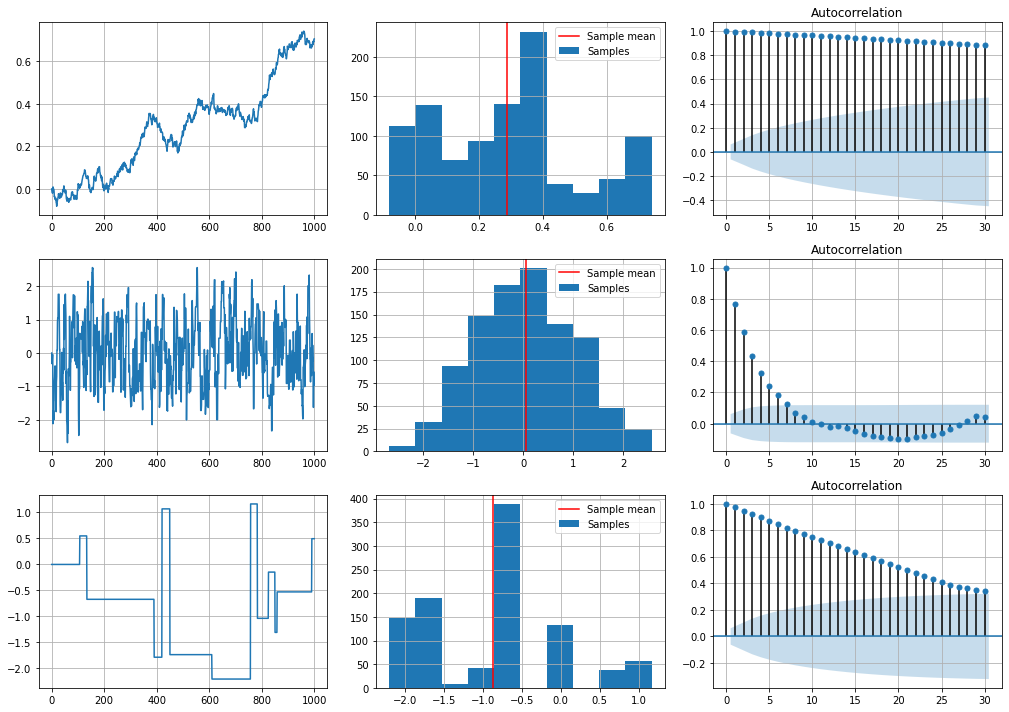

In [27]:
target = norm(loc=0, scale=1)
proposals = [norm, norm, norm]
proposals_scales = [.01, 1., 100.]

nsamples = 1000
xs = np.zeros((3, nsamples))
xs_rej = []

for t in range(nsamples-1):
    for i, (proposal, scale) in enumerate(zip(proposals, proposals_scales)):
        x_candidate = proposal.rvs(loc=xs[i,t], scale=scale)
        fraction = target.pdf(x_candidate) / target.pdf(xs[i,t])
        u = uniform.rvs()
        if u <= np.min([1, fraction]):
            xs[i,t+1] = x_candidate
        else:
            xs[i,t+1] = xs[i,t]
            
plt.figure(figsize=(14,10))
for i in range(len(proposals)):
    plt.subplot(3,3,3*i+1)
    plt.plot(xs[i])
    plt.subplot(3,3,3*i+2)
    plt.hist(xs[i], label='Samples')
    plt.axvline(xs[i].mean(), color='red', label='Sample mean')
    plt.legend()
    plt.subplot(3,3,3*i+2)
    ax = plt.subplot(3,3,3*i+3)
    plot_acf(xs[i], ax=ax);
plt.tight_layout()

### Issue 3: Initialization (solution: burn-in)

It may happen that we start our samples in a region where the target density is very low. The chain may then move to the region where the target is concentrated relatively slowly. This initial period is usually called the **burn-in** and we simply drop these samples. The length is chosen heuristically.

Let us demonstrate this on the first example code:

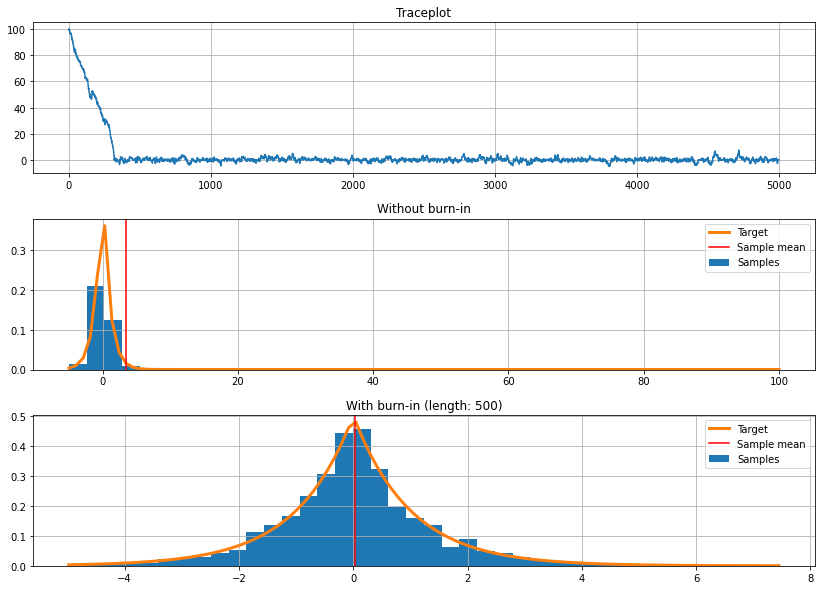

In [48]:
target = laplace()
proposal = norm
proposal_scale = 1

burnin = 500

nsamples = 5000
x = np.zeros(nsamples)
x[0] = 100

for t in range(nsamples-1):
    x_candidate = proposal.rvs(loc=x[t], scale=proposal_scale)
    fraction = target.pdf(x_candidate)
    fraction /= target.pdf(x[t])
    alpha = np.min([1, fraction])
    u = uniform.rvs()
    if u <= alpha:
        x[t+1] = x_candidate
    else:
        x[t+1] = x[t]
        
plt.figure(1, figsize=(14,10))
plt.subplot(311)
plt.plot(x)
plt.title("Traceplot")
plt.subplot(312)
plt.title(f'Without burn-in')
plt.hist(x, bins=40, density=True, label='Samples')
plt.plot(np.linspace(x.min(), x.max(),100), target.pdf(np.linspace(x.min(),x.max(),100)), lw=3, label='Target')
plt.axvline(x.mean(), color='red', label='Sample mean')
plt.legend()
plt.subplot(313)
plt.title(f'With burn-in (length: {burnin})')
plt.hist(x[burnin:], bins=40, density=True, label='Samples')
plt.plot(np.linspace(x[burnin:].min(), x[burnin:].max(),100), 
         target.pdf(np.linspace(x[burnin:].min(),x[burnin:].max(),100)), lw=3, label='Target')
plt.axvline(x[burnin:].mean(), color='red', label='Sample mean')
plt.legend()

## Monitoring convergence

This is a VERY convoluted part of MCMC and thus far beyond the scope of the course. However, we already know, that *stan* will raise warnings if something goes wrong.

For somewhat more info, see [Section 15](https://mc-stan.org/docs/2_19/reference-manual/analysis-chapter.html) of the *stan* manual.